# Dog Breed Classification

Writer: E.W

Date: 2024/05/28

## Data Preparation

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd 
import numpy as np
prefix = '/kaggle/input/dog-breed-identification/'
df = pd.read_csv(prefix + 'labels.csv')
filenames = [prefix + 'train/'+ id + '.jpg' for id in df.id]
filenames[:5]

['/kaggle/input/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/kaggle/input/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/kaggle/input/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/kaggle/input/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/kaggle/input/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

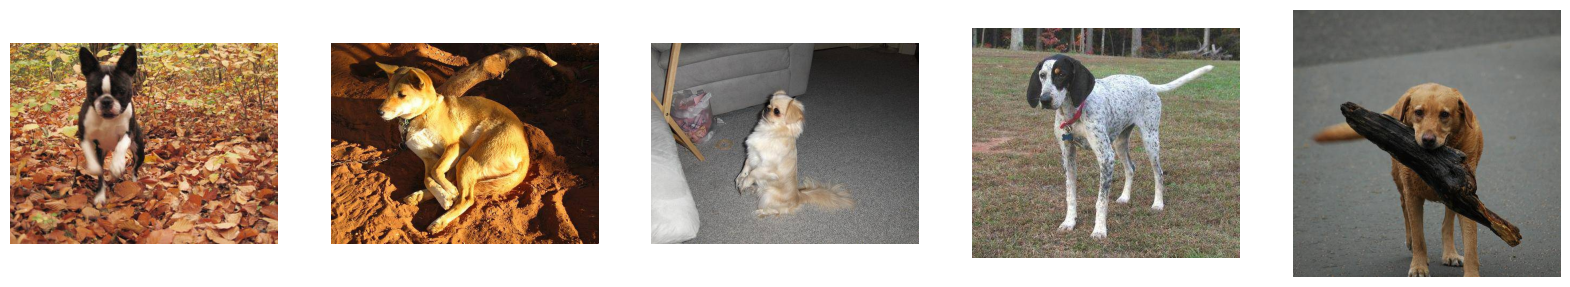

In [3]:
# Check the image
from PIL import Image
import matplotlib.pyplot as plt
images = [Image.open(path) for path in filenames[:5]]
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')  

plt.show()

Text(0, 0.5, 'Number of Class')

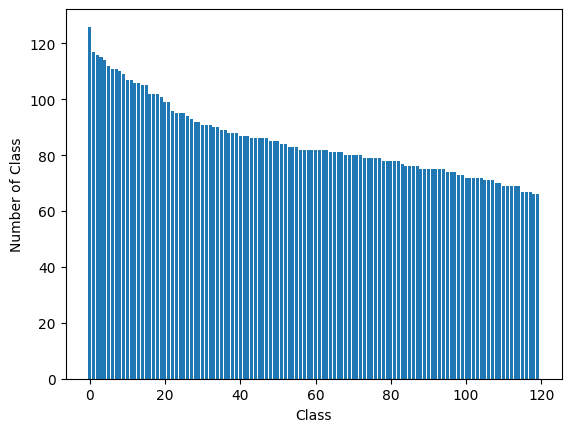

In [4]:
# Check the distribution of Class
count = df['breed'].value_counts()
count
plt.bar(range(len(df.breed.unique())), count)
plt.xlabel("Class")
plt.ylabel("Number of Class")

**Conclusion:** The distribution of each category is relatively balanced, and there is no need to use some special methods to deal with data imbalance.

## CNN Model -- resnet50

From the previous work, digit classification, CNN is better than SVM, especially better than linear SVM on image classification. In this case, I don't do the comparison between those two for the well-known conclusion.

Use pretrained model for saving time and improving accuracy.

In [5]:
# Split data to Train/Validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
X = np.array(filenames)
y = encoder.fit_transform(df.breed)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,y_train.shape

((8177,), (8177,))

In [6]:
from torch.utils.data import Dataset, DataLoader
# This Class is built for:
# 1.Make sure images are 'RGB' formatted
# 2.Transform Data
class TorchDataset(Dataset):
    def __init__(self, filenames, labels, root_dir, transform=None):
        assert len(filenames) == len(labels)
        self.filenames = filenames
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        label = self.labels[item]
        img_name = os.path.join(self.root_dir, self.filenames[item])

        with Image.open(img_name) as f:
            img = f.convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [7]:
"""
To avoid overfit, add noise into the initial data
1. Random cropping, first enlarge the image a little, 
and then crop the image to a specified size at a random position
2. Randomly rotate and flip images. Rotation shouldn't change the dog's breed in reality.
3. Image standardization, the params are the default.
""" 
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Batch load
BATCH_SIZE = 32
train_dataset = TorchDataset(X_train, y_train, prefix + 'train/', transform=train_transform)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_dataset = TorchDataset(X_test, y_test, prefix + 'train/', transform=test_transform)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

print(len(train_dataset))
print(len(test_dataset))

8177
2045


In [9]:
# Use pre-trained model resnet50 t
import torchvision
import torch
from torchvision.models import resnet50, ResNet50_Weights
n_class = 120 # Number of dog breeds
model = resnet50(weights = ResNet50_Weights.DEFAULT) # Load pretrained model
for param in model.parameters():
    param.requires_grad = False # Freeze all layers
model.fc = torch.nn.Linear(2048, n_class) # Get 120 classes

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s] 


In [10]:
loss_func = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001) 

In [11]:
# train
def train(model, data_loader, optimizer, loss_func):
    model.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_loss, train_accuracy = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_func(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_labels = torch.argmax(y_pred, 1)
        train_accuracy += torch.sum(y == y_pred_labels).item()
    train_loss /= len(data_loader)
    train_accuracy = 100.0 * train_accuracy / len(data_loader.dataset)
    print(f"Train loss: {train_loss:.5f} | Train Accuracy: {train_accuracy:.5f}")

In [12]:
# test
def test(model, data_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loss, test_accuracy = 0, 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred_labels = torch.argmax(y_pred, dim=1)
            test_accuracy += torch.sum(y == y_pred_labels).item()
            loss = loss_func(y_pred, y)
            test_loss += loss.item()
    test_accuracy = 100.0 * test_accuracy / len(data_loader.dataset)
    test_loss /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.5f}")


In [13]:
for i in range(10):
    print(f"Epoch {i+1}")
    train(model, train_loader, optimizer, loss_func)
    test(model, test_loader)

Epoch 1
Train loss: 4.41322 | Train Accuracy: 19.99511
Test loss: 4.10446 | Test accuracy: 41.46699
Epoch 2
Train loss: 3.71398 | Train Accuracy: 56.73230
Test loss: 3.55476 | Test accuracy: 60.73350
Epoch 3
Train loss: 3.15562 | Train Accuracy: 71.15079
Test loss: 3.08889 | Test accuracy: 68.70416
Epoch 4
Train loss: 2.68356 | Train Accuracy: 77.10652
Test loss: 2.68839 | Test accuracy: 72.56724
Epoch 5
Train loss: 2.28421 | Train Accuracy: 80.76312
Test loss: 2.36973 | Test accuracy: 76.03912
Epoch 6
Train loss: 1.96512 | Train Accuracy: 83.09894
Test loss: 2.09437 | Test accuracy: 77.31051
Epoch 7
Train loss: 1.70384 | Train Accuracy: 84.83551
Test loss: 1.86943 | Test accuracy: 78.48411
Epoch 8
Train loss: 1.48773 | Train Accuracy: 86.14406
Test loss: 1.66634 | Test accuracy: 78.97311
Epoch 9
Train loss: 1.31134 | Train Accuracy: 87.17133
Test loss: 1.51905 | Test accuracy: 81.02689
Epoch 10
Train loss: 1.16867 | Train Accuracy: 87.61159
Test loss: 1.39402 | Test accuracy: 82.64059

## Conclusion

From the result, the accuray is not as good as the previous work, digit classifaction. It may be improved by changing models or add more layers.